In [51]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from mnist import MNIST
from sklearn.preprocessing import OneHotEncoder
#import tensorflow_datasets as tfds

In [52]:
def load_data():
    """
    loads data from local folder Data/.
    converts the array.array objects to numpy ndarrays
    """
    mndata = MNIST('./Data')
    train_X, train_Y = mndata.load_training()
    test_X, test_Y = mndata.load_testing()
    train_X =np.asarray(train_X)
    test_X = np.asarray(test_X)
    train_Y = np.asarray(train_Y)
    test_Y = np.asarray(test_Y)
    return train_X, train_Y, test_X, test_Y

In [53]:
def preprocess_image_data(image_data):
    """
    takes in an array object that is assumed to be X image data for MNIST.
    reshape to get grayscale 28x28 images for each row.
    converts array to float and normalizes values betweeen 0 and 1
    
    param image_data: a array.array object that is training or test data
    return image_array_norm: normalized image array
    """
    image_array = np.reshape(image_data, (image_data.shape[0], 28, 28, 1))
    image_array = image_array.astype(np.float32)
    image_array_norm = image_array / 255.0
    return image_array_norm

In [54]:
def preprocess_label_data(label_data):
    """
    takes in an array object and reshapes to 2D array. 
    One hot encodes labels since they are categorical.
    
    param label_data: label data
    return encoded_labels: (-1,10) array of encoded data labels
    """
    label_array = label_data.reshape(-1, 1)
    hot_encoder = OneHotEncoder(dtype=np.uint8)
    hot_encoder.fit(label_array)
    encoded_labels = hot_encoder.transform(label_array).toarray()
    return encoded_labels

In [55]:
# load MNIST data set
Xtrain, Ytrain, Xtest, Ytest = load_data()

In [41]:
# find out if dataset is balanced 
def visualize_balance_of_dataset(y, name):
    """
    output bar chart showing number of elements
    for multiclass (0, 1, 2,...9). 
    
    Used to visualize how balanced the data set is. 
    
    param y: label array
    """
    u, counts = np.unique(y, return_counts=True)
    sum_counts = np.sum(counts)
    distro_list = []
    for i in counts:
        distro =(i / sum_counts) * 100
        distro_list.append(distro)
    # print('distribution = ', distro_list)    
    plt.figure(figsize=(10, 5))
    if name == "Train":
        col = "blue"
    else:
        col = "red"
    plt.bar(u, counts, color=col)
    plt.title(name + " Dataset Distribution")
    plt.xticks(np.arange(min(u), max(u)+1, 1.0))
    plt.xlabel("Label Values - Numerical Characters")
    plt.ylabel("Number of Label Value Occurrences")
    plt.savefig(name + "_barChart.png")

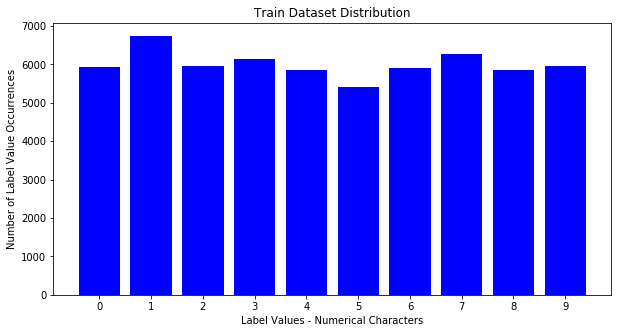

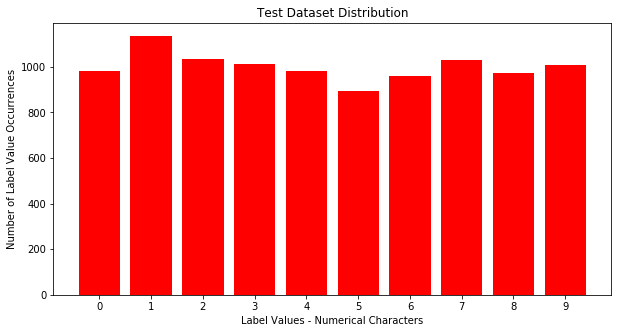

In [42]:
visualize_balance_of_dataset(Ytrain, "Train")
visualize_balance_of_dataset(Ytest, "Test")

In [56]:
Xtrain = preprocess_image_data(Xtrain)
Xtest = preprocess_image_data(Xtest)

In [57]:
# preprocess training and test labels 
Ytrain = preprocess_label_data(Ytrain)
Ytest = preprocess_label_data(Ytest)

In [58]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [59]:
def create_CNNmodel():
    # add layers for CNN
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def split_train_evaluate(Xtrain, Ytrain):
    history_list = []
    accuracy_list = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)
    for i, j in kfold.split(Xtrain):
        Xtrain_fold, Ytrain_fold = Xtrain[i], Ytrain[i]
        print(Xtrain_fold.shape)
        print('Y', Ytrain_fold.shape)
        XVal_fold, YVal_fold = Xtrain[j], Ytrain[j]
        cnn = create_CNNmodel()
        history = cnn.fit(Xtrain_fold, Ytrain_fold, epochs=10, batch_size=32, validation_data=(XVal_fold, YVal_fold), verbose=0)
        _, acc = cnn.evaluate(XVal_fold, YVal_fold, verbose=1)
        history_list.append(history)
        accuracy_list.append(acc)
        print('accuracy = %.3f' % (acc * 100.0))
    return history_list, accuracy_list

In [13]:
hList, aList = split_train_evaluate(Xtrain, Ytrain)

(48000, 28, 28, 1)
Y (48000, 10)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
12000/12000 [==============================] - 3s 236us/step
> 98.525
(48000, 28, 28, 1)
Y (48000, 10)
12000/12000 [==============================] - 3s 272us/step
> 98.750
(48000, 28, 28, 1)
Y (48000, 10)
12000/12000 [==============================] - 3s 244us/step
> 98.975
(48000, 28, 28, 1)
Y (48000, 10)
12000/12000 [==============================] - 3s 214us/step
> 98.608
(48000, 28, 28, 1)
Y (48000, 10)
12000/12000 [==============================] - 3s 276us/step
> 98.542


In [60]:
def train_evaluate(Xtrain, Ytrain, Xtest, Ytest):
    cnn = create_CNNmodel()
    history = cnn.fit(Xtrain, Ytrain, batch_size=32, epochs=15, validation_split=0.1)
    _, accuracy = cnn.evaluate(Xtest, Ytest, verbose=1)
    print('accuracy %.2f' % accuracy)
    cnn.save('cnn_model')
    return history, accuracy

In [61]:
history, accuracy = train_evaluate(Xtrain, Ytrain, Xtest, Ytest)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 29s 543us/step - loss: 0.1734 - accuracy: 0.9465 - val_loss: 0.0653 - val_accuracy: 0.9825
Epoch 2/15
54000/54000 [==============================] - 29s 530us/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0505 - val_accuracy: 0.9878
Epoch 3/15
54000/54000 [==============================] - 28s 528us/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0490 - val_accuracy: 0.9885
Epoch 4/15
54000/54000 [==============================] - 29s 543us/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.0509 - val_accuracy: 0.9863
Epoch 5/15
54000/54000 [==============================] - 30s 554us/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0436 - val_accuracy: 0.9877
Epoch 6/15
54000/54000 [==============================] - 31s 572us/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0453 - val_accuracy: 0.9888
Epoch 7/15
54000/54000 [==============================] -

In [62]:
cnn = create_CNNmodel()
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               540900    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________
